### Jonathan Mitchell
#### Self-Driving-Car Nanodegree
#### Twitter: [@jonathancmitch](https://twitter.com/jonathancmitch)
#### Linkedin: [https://www.linkedin.com/in/jonathancmitchell](https://twitter.com/jonathancmitch)
#### Github: [github.com/jonathancmitchell](github.com/jonathancmitchell)
#### Medium: [https://medium.com/@jmitchell1991](https://medium.com/@jmitchell1991)
#### 2/24/2017

In [15]:
import matplotlib.pyplot as plt
import tensorflow as tf
import matplotlib.gridspec as gridspec
import cv2
import matplotlib.image as mpimg
import os
import pickle
import pandas as pd
from sklearn.utils import shuffle
import numpy as np
from sklearn.model_selection import train_test_split
%matplotlib inline

## Acquisition Functions

In [16]:
def createDataFrame(data_path):
    """
    input: data_path: path to data
    return: data frame
    """
    data_frame = pd.read_csv(data_path)
    data_frame.columns = ['center', 'left', 'right', 'steering', 'throttle', 'brake', 'speed']
    return data_frame

### Split data into left turns, right turns, center (no turns)

In [17]:
def createTrainingDataPathsCLR(df, prefix_path):
    """
    creates training data and training labels/ measurements from a data frame
    inputs:
    df: pandas DataFrame object
    prefix_path: path to the dataset
    output: (center_turns, left_turns, right_turns) list tuple
    """    
    # Turn types
    center_turns = []
    left_turns = []
    right_turns = []
    
    
    abs_path_to_IMG = os.path.abspath(prefix_path)
    for idx, row in df.iterrows():
        center_image_cam = os.path.join(abs_path_to_IMG, row['center'].strip())
        left_image_cam = os.path.join(abs_path_to_IMG, row['left'].strip())
        right_image_cam = os.path.join(abs_path_to_IMG, row['right'].strip())
        steering_angle = row['steering']
        
        # Right image condition
        if steering_angle > 0.125:
            right_turns.append([center_image_cam, left_image_cam, right_image_cam, steering_angle])
            
        # This is a left image
        elif steering_angle < -1 * 0.125:
            left_turns.append([center_image_cam, left_image_cam, right_image_cam, steering_angle])
            
        # This is a center image
        else:
        # center images
            center_turns.append([center_image_cam, left_image_cam, right_image_cam, steering_angle])
        
    return (center_turns, left_turns, right_turns)

In [18]:
def makeMore(dataArray, amount):
    """
    This function creates additional data for center, left, and right camera angles 
    given a dataArray of a specific turn type (center_turn, left_turn, or right_turn)
    input: 
    dataArray: array of specific turn type
    amount: amount to increase the input array
    output: dataArray of same turn type with values * amount
    """
    for i in range(len(dataArray)):
        for j in range(amount):                                    
            dataArray.append([dataArray[i][0], dataArray[i][1], dataArray[i][2], dataArray[i][3]])
    return dataArray

## Prepare training data

### Create data from udacity

#### Create Data Frame

In [19]:
data_pd_udacity = createDataFrame('data/driving_log.csv')
columns = ['center', 'left', 'right', 'steering']

In [20]:
data_pd_udacity.tail(10)

,center,left,right,steering,throttle,brake,speed
8026,IMG/center_2016_12_01_13_46_38_497.jpg,IMG/left_2016_12_01_13_46_38_497.jpg,IMG/right_2016_12_01_13_46_38_497.jpg,0.0,0.0,0.0,1.436795
8027,IMG/center_2016_12_01_13_46_38_543.jpg,IMG/left_2016_12_01_13_46_38_543.jpg,IMG/right_2016_12_01_13_46_38_543.jpg,0.0,0.0,0.0,1.431010
8028,IMG/center_2016_12_01_13_46_38_599.jpg,IMG/left_2016_12_01_13_46_38_599.jpg,IMG/right_2016_12_01_13_46_38_599.jpg,0.0,0.0,0.0,1.422377
8029,IMG/center_2016_12_01_13_46_38_644.jpg,IMG/left_2016_12_01_13_46_38_644.jpg,IMG/right_2016_12_01_13_46_38_644.jpg,0.0,0.0,0.0,1.416651
8030,IMG/center_2016_12_01_13_46_38_700.jpg,IMG/left_2016_12_01_13_46_38_700.jpg,IMG/right_2016_12_01_13_46_38_700.jpg,0.0,0.0,0.0,1.408105
8031,IMG/center_2016_12_01_13_46_38_745.jpg,IMG/left_2016_12_01_13_46_38_745.jpg,IMG/right_2016_12_01_13_46_38_745.jpg,0.0,0.0,0.0,1.402436
8032,IMG/center_2016_12_01_13_46_38_802.jpg,IMG/left_2016_12_01_13_46_38_802.jpg,IMG/right_2016_12_01_13_46_38_802.jpg,0.0,0.0,0.0,1.393976
8033,IMG/center_2016_12_01_13_46_38_846.jpg,IMG/left_2016_12_01_13_46_38_846.jpg,IMG/right_2016_12_01_13_46_38_846.jpg,0.0,0.0,0.0,1.388364
8034,IMG/center_2016_12_01_13_46_38_922.jpg,IMG/left_2016_12_01_13_46_38_922.jpg,IMG/right_2016_12_01_13_46_38_922.jpg,0.0,0.0,0.0,1.377208
8035,IMG/center_2016_12_01_13_46_38_947.jpg,IMG/left_2016_12_01_13_46_38_947.jpg,IMG/right_2016_12_01_13_46_38_947.jpg,0.0,0.0,0.0,1.374433


#### Create centers_turns, left_turns, right_turns

In [21]:
(center_turns_udacity,
left_turns_udacity,
right_turns_udacity) = createTrainingDataPathsCLR(data_pd_udacity, 'data/')

#### Make more copies

In [22]:
center_turns_udacity = makeMore(center_turns_udacity, 5)
left_turns_udacity = makeMore(left_turns_udacity, 18)
right_turns_udacity = makeMore(right_turns_udacity, 12)

In [23]:
df_center_udacity = pd.DataFrame(center_turns_udacity, columns = columns)
df_left_udacity = pd.DataFrame(left_turns_udacity, columns = columns)
df_right_udacity = pd.DataFrame(right_turns_udacity, columns = columns)

print('df_center_udacity.index: ', len(df_center_udacity.index))
print('df_left_udacity.index: ', len(df_left_udacity.index))
print('df_right_udacity.index: ', len(df_right_udacity.index))


df_center_udacity.index:  36714
df_left_udacity.index:  16131
df_right_udacity.index:  13884


#### Histogram Visualization

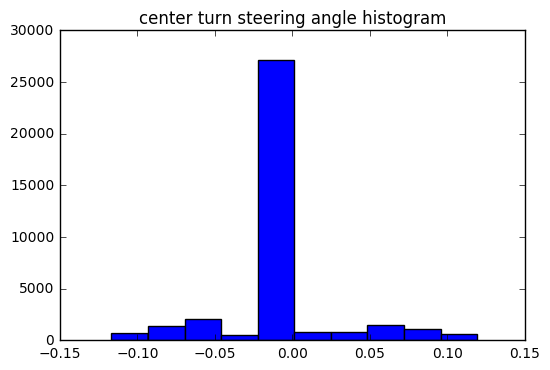

In [24]:
plt.hist(np.asarray(df_center_udacity['steering'], dtype=np.float32))
plt.title('center turn steering angle histogram')
# plt.hist(np.asarray(df_center_udacity['steering'], dtype=np.float32),bins=100,range=(-0.2,0.2),facecolor="r", histtype = 'step')

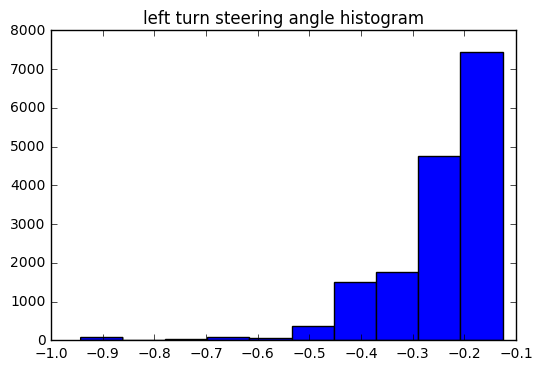

In [25]:
plt.hist(np.asarray(df_left_udacity['steering'], dtype=np.float32))
plt.title('left turn steering angle histogram')
# plt.hist(np.asarray(df_left_udacity['steering'], dtype=np.float32),bins=100,range=(-0.6,0.15),facecolor="r", histtype = 'step')

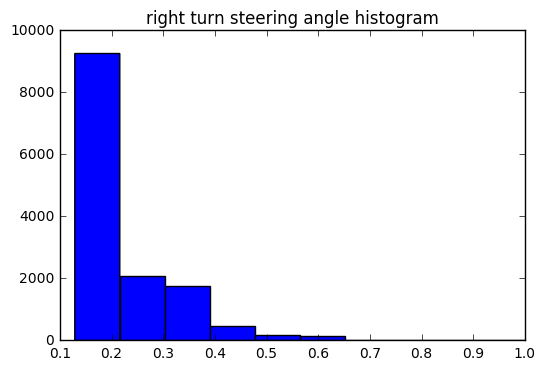

In [26]:
plt.hist(np.asarray(df_right_udacity['steering'], dtype=np.float32))
plt.title('right turn steering angle histogram')
# plt.hist(np.asarray(df_right_udacity['steering'], dtype=np.float32),bins=100,range=(0.15,0.6),facecolor="r", histtype = 'step')

#### Shuffle

In [27]:
df_center_udacity = shuffle(df_center_udacity)
df_left_udacity = shuffle(df_left_udacity)
df_right_udacity = shuffle(df_right_udacity)

#### Concat

In [28]:
frames_to_concat_udacity = [df_center_udacity, df_left_udacity, df_right_udacity]
df_udacity = pd.concat(frames_to_concat_udacity, axis = 0, join = 'outer', ignore_index=False)

### Create data from recovery

#### Create Data Frame

In [19]:
data_pd_recovery = createDataFrame('a_recovery/driving_log_recovery.csv')
columns = ['center', 'left', 'right', 'steering']

#### Create centers_turns, left_turns, right_turns

In [20]:
(center_turns_recovery,
left_turns_recovery,
right_turns_recovery) = createTrainingDataPathsCLR(data_pd_recovery, 'a_recovery/')

#### Make more copies

In [21]:
center_turns_recovery = makeMore(center_turns_recovery, 5)
left_turns_recovery = makeMore(left_turns_recovery, 18)
right_turns_recovery = makeMore(right_turns_recovery, 12)

In [22]:
df_center_recovery = pd.DataFrame(center_turns_recovery, columns = columns)
df_left_recovery = pd.DataFrame(left_turns_recovery, columns = columns)
df_right_recovery= pd.DataFrame(right_turns_recovery, columns = columns)

In [23]:
print('df_center_recovery.index: ', len(df_center_recovery.index))
print('df_left_recovery.index: ', len(df_left_recovery.index))
print('df_right_recovery.index: ', len(df_right_recovery.index))

df_center_recovery.index:  4308
df_left_recovery.index:  6213
df_right_recovery.index:  3926


#### Histogram Visualization

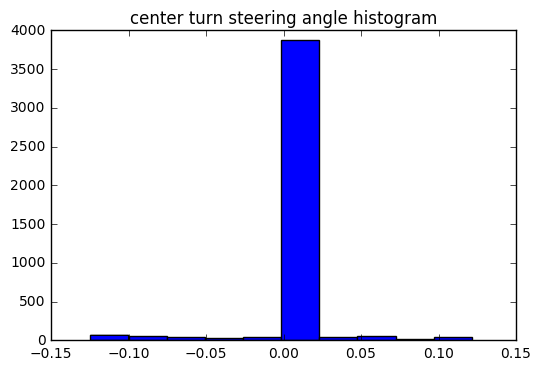

In [24]:
plt.hist(np.asarray(df_center_recovery['steering'], dtype=np.float32))
plt.title('center turn steering angle histogram')
# plt.hist(np.asarray(df_center_recovery['steering'], dtype=np.float32),bins=100,range=(-0.2,0.2),facecolor="r", histtype = 'step')

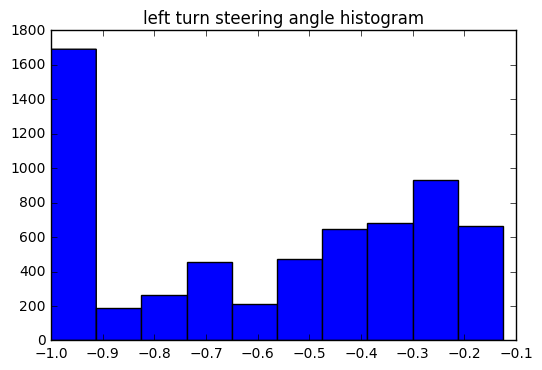

In [25]:
plt.hist(np.asarray(df_left_recovery['steering'], dtype=np.float32))
plt.title('left turn steering angle histogram')
# plt.hist(np.asarray(df_left_recovery['steering'], dtype=np.float32),bins=100,range=(-0.2,0.2),facecolor="r", histtype = 'step')

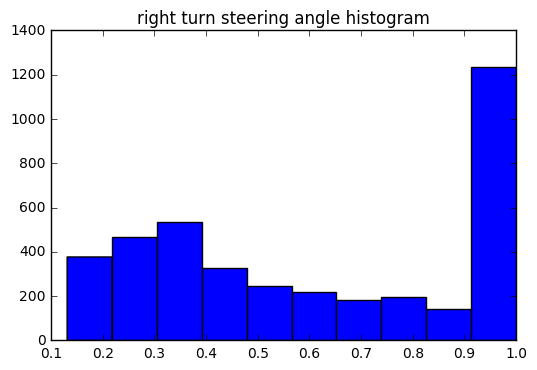

In [26]:
plt.hist(np.asarray(df_right_recovery['steering'], dtype=np.float32))
plt.title('right turn steering angle histogram')

# plt.hist(np.asarray(df_right_recovery['steering'], dtype=np.float32),bins=100,range=(-0.2,0.2),facecolor="r", histtype = 'step')

#### Shuffle

In [27]:
df_center_recovery = shuffle(df_center_recovery)
df_left_recovery = shuffle(df_left_recovery)
df_right_recovery = shuffle(df_right_recovery)

#### Concat

In [28]:
frames_to_concat_recovery = [df_center_recovery, df_left_recovery, df_right_recovery]
df_recovery = pd.concat(frames_to_concat_recovery, axis = 0, join = 'outer', ignore_index=False)

### Concat both dataframes together (Udacity + Recovery)

In [29]:
frames = [df_udacity, df_recovery]
train_data = pd.concat(frames, axis = 0, join = 'outer', ignore_index=False)

In [30]:
print('train_data size: ', len(train_data.index))

train_data size:  81176


### Shuffle again

In [31]:
train_data = shuffle(train_data)

### Train Test Split

In [32]:
train_data, valid_data = train_test_split(train_data, test_size = 0.2)
print('train_data size: ', len(train_data.index))
print('valid_data size: ', len(valid_data.index))

train_data size:  64940
valid_data size:  16236


#### Histogram of steering angles training data

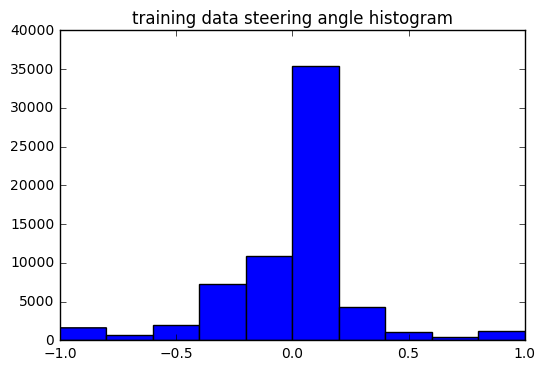

In [33]:
plt.hist(np.asarray(train_data['steering']))
plt.title('training data steering angle histogram')

## Preprocess

In [34]:
def lateral_shift(image):
    """
    This function takes in an image (RGB) and applies left and right affine translations
    input: image
    output: image(transformed)
    """
    pass

In [35]:
def flip_image(image, ang):
    image = np.fliplr(image)
    ang = -1 * ang
    return (image, ang)

In [36]:
def change_brightness(image):
    """
    Augments the brightness of the image by multiplying the saturation by a uniform random variable
    input: image (RGB)
    output: image with brightness augmentation (RGB)
    """
    bright_factor = 0.2 + np.random.uniform()
    
    hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    # perform brightness augmentation only on the second channel
    hsv_image[:,:,2] = hsv_image[:,:,2] * bright_factor
    
    # change back to RGB
    image_rgb = cv2.cvtColor(hsv_image, cv2.COLOR_HSV2RGB)
    return image_rgb
    
    

In [37]:
def preprocess_image(image):
    """
    Preprocess image, 
    input: image (original shape)
    output: image (shape is (220, 66, 3) )
    """    
    # crop shape
    image = image[image.shape[0] * 0.34:image.shape[0] * 0.875,:,:]
    # resize to (66, 220)
    img = cv2.resize(image, (220, 66), interpolation=cv2.INTER_AREA)
    return img


In [38]:
def preprocess_image_valid_from_path(image_path, steering_angle):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = preprocess_image(img)
    return img, steering_angle

In [39]:
def preprocess_image_from_path(image_path, steering_angle):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    img = change_brightness(img)
    # flip and reassign
    random_flip_factor = np.random.randint(2)
    if random_flip_factor == 0:
        img, steering_angle = flip_image(img, steering_angle)
    
        
    img = preprocess_image(img)
    return img, steering_angle

## Generators

##### Training

Here I created two generators, one for training data and one for validation data. In the training generator we create batches of 32 for each training sample. Therefore if I have `samples_per_epoch = 20480` that means for each of those samples (in 20480) I yield batch_size = 16 * 2 images from the training generator. I did this because it allows me to have control over what the batches turn out to be. In this case I give a 33% chance to switch the second center camera image with a left or right camera images and apply a correction factor to offset the angles of those camera images

##### Validation

In this generator I simply yield one image, angle tuple for each iteration. During training I used `samples_per_epoch = length of validation data` so it is running through all the validation data one by one

In [40]:

def generate_training_data(data, batch_size = 32):
    """
    We create a loop through out data and 
    send out an individual row in the dataframe to preprocess_image_from_path, 
    which is then sent to preprocess_image
    inputs: 
    data: pandas DataFrame
    batch_size: batch sizes, size to make each batch
    returns a yield a batch of (image_batch, label_batch)
    """    
    image_batch = np.zeros((batch_size * 2, 66, 220, 3)) # nvidia input params
    label_batch = np.zeros((batch_size * 2))
    while True:
        for i in range(batch_size):
            idx = np.random.randint(len(data))
            row = data.iloc[[idx]].reset_index()
            x, y = preprocess_image_from_path(row['center'].values[0], row['steering'].values[0])
            
            # preprocess another center image
            x2, y2 = preprocess_image_from_path(row['center'].values[0], row['steering'].values[0])
            
            if np.random.randint(3) == 1:
                # 33% chance to overwrite center image (2) with left image + correction_factor
                x2, y2 = preprocess_image_from_path(row['left'].values[0], row['steering'] + 0.125)
                
            if np.random.randint(3) == 2:
                # 33% change to overwrite center image (2) give right image - correction_factor
                x2, y2 = preprocess_image_from_path(row['right'].values[0], row['steering'] - 0.125)
            
            
            image_batch[i] = x
            label_batch[i] = y
            
            image_batch[i + 1] = x2
            label_batch[i + 1] = y2
            
        yield shuffle(image_batch, label_batch)
    
def generate_validation_data(data):
    """
    data: center camera images only, because thats what we observe (dataframe)
    yields: one image, angle
    """
    while True:
        for idx in range(len(data)):
            row = data.iloc[[idx]].reset_index()
            img, angle = preprocess_image_valid_from_path(row['center'].values[0], row['steering'].values[0])
            img = img.reshape(1, img.shape[0], img.shape[1], img.shape[2])
            angle = np.array([[angle]])
            yield img, angle
            

## Network

#### I chose to use Nvidia's network architecture. Input (220 x 66 sized image) output (1 steering angle)

I chose to use the Nvidia model architecture which can be found [here add link]
I used ELu's because they push mean unit activation functions closer to zero [https://arxiv.org/pdf/1511.07289v1.pdf]

In [41]:
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.core import Activation, Dropout, Flatten, Dense, Lambda
from keras.layers import ELU
from keras.optimizers import Adam
tf.python.control_flow_ops = tf


N_img_height = 66
N_img_width = 220
N_img_channels = 3
def nvidia_model():
    inputShape = (N_img_height, N_img_width, N_img_channels)

    model = Sequential()
    # normalization
    model.add(Lambda(lambda x: x/ 127.5 - 1, input_shape = inputShape))

    model.add(Convolution2D(24, 5, 5, 
                            subsample=(2,2), 
                            border_mode = 'valid',
                            init = 'he_normal',
                            name = 'conv1'))
    
    model.add(ELU())    
    model.add(Convolution2D(36, 5, 5, 
                            subsample=(2,2), 
                            border_mode = 'valid',
                            init = 'he_normal',
                            name = 'conv2'))
    
    model.add(ELU())    
    model.add(Convolution2D(48, 5, 5, 
                            subsample=(2,2), 
                            border_mode = 'valid',
                            init = 'he_normal',
                            name = 'conv3'))
    model.add(ELU())
    model.add(Dropout(0.5))
    model.add(Convolution2D(64, 3, 3, 
                            subsample = (1,1), 
                            border_mode = 'valid',
                            init = 'he_normal', #gaussian init
                            name = 'conv4'))
    
    model.add(ELU())              
    model.add(Convolution2D(64, 3, 3, 
                            subsample= (1,1), 
                            border_mode = 'valid',
                            init = 'he_normal',
                            name = 'conv5'))
              
              
    model.add(Flatten(name = 'flatten'))
    model.add(ELU())
    model.add(Dense(100, init = 'he_normal', name = 'fc1'))
    model.add(ELU())
    model.add(Dense(50, init = 'he_normal', name = 'fc2'))
    model.add(ELU())
    model.add(Dense(10, init = 'he_normal', name = 'fc3'))
    model.add(ELU())
    
    # do not put activation at the end because we want to exact output, not a class identifier
    model.add(Dense(1, name = 'output', init = 'he_normal'))
    
    adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    model.compile(optimizer = adam, loss = 'mse')

    return model


Using TensorFlow backend.


In [42]:
val_size = len(valid_data.index)
valid_generator = generate_validation_data(valid_data)
BATCH = 16

In [43]:
model = nvidia_model()
train_size = len(train_data.index)
for i in range(3):
    train_generator = generate_training_data(train_data, BATCH)
    history = model.fit_generator(
            train_generator, 
            samples_per_epoch = 20480, # try putting the whole thing in here in the future
            nb_epoch = 6,
            validation_data = valid_generator,
            nb_val_samples = val_size)
    print(history)
    
    model.save_weights('model-weights-F1.h5')
    model.save('model-F1.h5')

Epoch 1/6


/home/jj/anaconda2/envs/python3/lib/python3.5/site-packages/ipykernel/__main__.py:8: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


20480/20480 [==============================] - 111s - loss: 0.0299 - val_loss: 0.0466
Epoch 2/6
20480/20480 [==============================] - 103s - loss: 0.0247 - val_loss: 0.0426
Epoch 3/6
20480/20480 [==============================] - 101s - loss: 0.0226 - val_loss: 0.0419
Epoch 4/6
20480/20480 [==============================] - 114s - loss: 0.0208 - val_loss: 0.0381
Epoch 5/6
20480/20480 [==============================] - 106s - loss: 0.0189 - val_loss: 0.0328
Epoch 6/6
20480/20480 [==============================] - 103s - loss: 0.0198 - val_loss: 0.0313
Epoch 1/6
20480/20480 [==============================] - 98s - loss: 0.0179 - val_loss: 0.0304
Epoch 2/6
20480/20480 [==============================] - 100s - loss: 0.0179 - val_loss: 0.0326
Epoch 3/6
20480/20480 [==============================] - 107s - loss: 0.0180 - val_loss: 0.0305
Epoch 4/6
20480/20480 [==============================] - 106s - loss: 0.0169 - val_loss: 0.0280
Epoch 5/6
20480/20480 [============================

## Visualizing Loss

dict_keys(['val_loss', 'loss'])


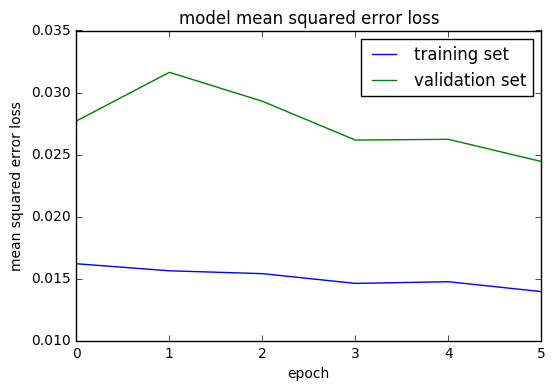

In [47]:
print(history.history.keys())

### plot the training and validation loss for each epoch
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()

### RANDOM TEST

### Visualize preprocessing

Randomly select some data points and show how our preprocessing affects the images

/home/jj/anaconda2/envs/python3/lib/python3.5/site-packages/ipykernel/__main__.py:8: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


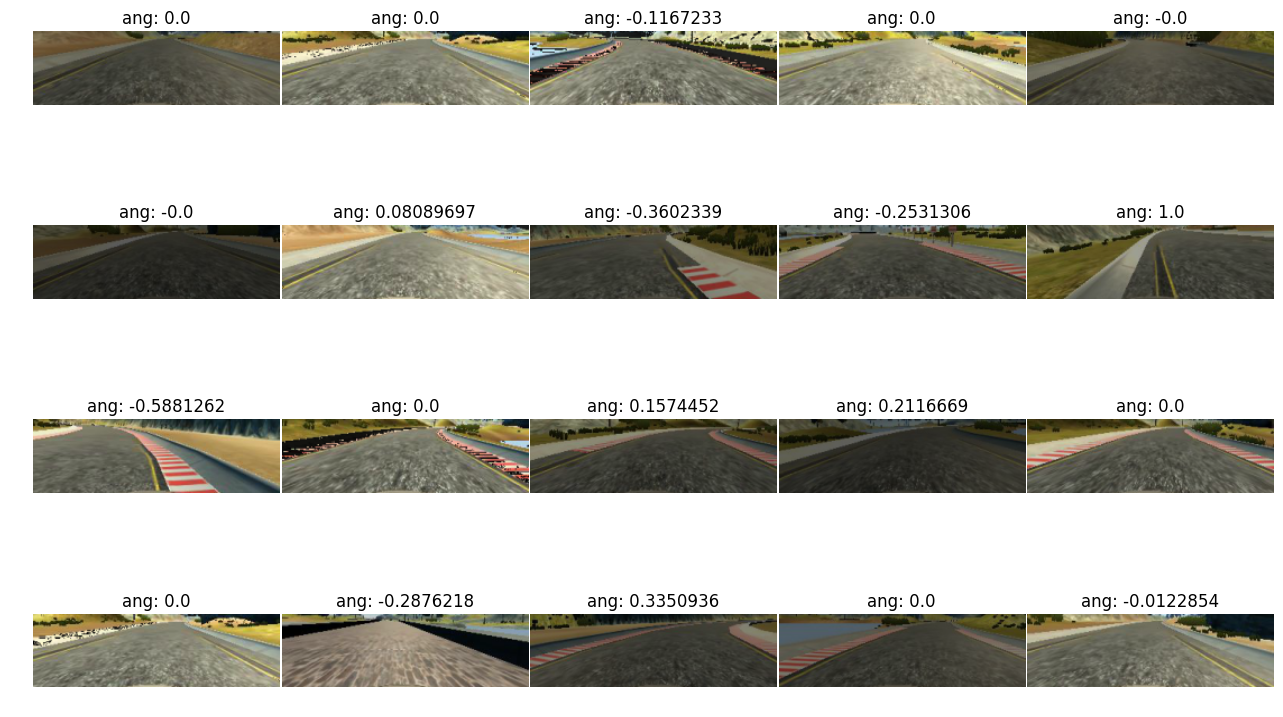

In [45]:
# random selection
data = train_data
random_images = []
for i in range(20):
    idx = np.random.randint(len(data))
    row = data.iloc[[idx]].reset_index()
    x, y = preprocess_image_from_path(row['center'].values[0], row['steering'].values[0])
    random_images.append((x, y))
    
plt.figure(figsize=(16, 10))
gs1 = gridspec.GridSpec(4, 5)
gs1.update(wspace = 0.01, hspace = 0.01)
for idx, image in enumerate(random_images):
    angle = 'ang: ' + str(image[1]) 
    ax1 = plt.subplot(gs1[idx])
    ax1.axis('off')
    plt.title(angle)
    plt.imshow(image[0])
plt.show()

## Explanation

### Data Acquisition

### Gathering data

I primarily used udacity's data and a recovery dataset. The recovery data was hard to gather because I do not have a controller. Udacity's provided data 

##### Data Harnessing
At first I created a separate data acquisition file where I would acquire all my data, modify it, and then save it to a pickle file, and then import that data using the file where I would train my network. This eventually became too difficult to work with as the complexity of the project increased I found myself going between two files, and just hoping that I was passing the correct data through a pickle file. Eventually I decided to write everything in this jupyter notebook.

#### Data sorting
I used pandas dataframes to sort through my data and aggregate it. This was extremely helpful because it allowed me to distinguish between turn types and camera types (center_cam, left_cam, right_cam). I took this approach after trying many times to use numpy arrays. With the numpy array implementation I was passing two arrays into my generators, with the dataframe implementation I only have to pass through the dataframe. This made life simpler

#### Arrays vs Dataframes

I had multiple implementations of this program. One was using numpy arrays, and the other is using dataframes. When I was using numpy arrays I had no way to nicely sort the center_turns, left_turns, and right_turns from each other because I simply concatenated them together into one large training array. I soon realized needed to separate each turn type in order to add more of some turns to balance out the histogram of steering angles. I had so many angles ~0 degrees (which is just the car going straight). Pandas dataframes were a great options for this. 

Originally I was just pushing all the images into an array, adding a correction factor to the left_cam images and subtracting a correction factor from the right images. However this was extremely inefficient. After choosing the pandas DataFrame method I was able to add the correction factor to left_camera and right_camera images on the fly and send them through the preprocessing pipeline

#### Data Creation

I added additional data from the existing data in this dataset to attempt to get a more uniform distribution of turn types. I added `18 X left_turns` and `12 x right_turns`. This was because my first goal was to get it working on track 1. In order to generalize to track two I should probably use `15 X left_turns` and `15 X right_turns`

#### Histogram of steering angles

When we are acquiring data on the track, we are primarily driving straight. So as you can see most of our steering angle values are 0 or very close to it. In order to train my model to turn as needed I had to try to get as close to a gaussian distribution of center_turns, left_turns, and right_turns. I chose gaussian as a goal because that would work on a track that is primarily straight (66% straight), and not primarily turn-based (33% turns) which is what I estimate the second track to be. Here we can observe the difference

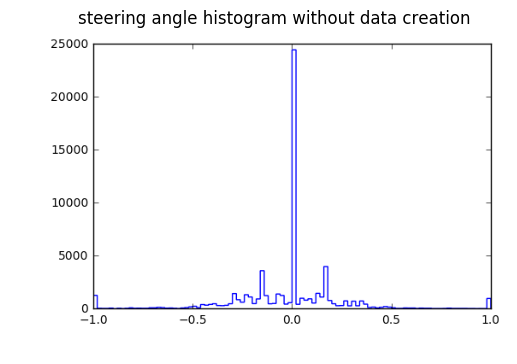

In [3]:
hist_with_creation = mpimg.imread('train_data_steering.png')
plt.title('steering angle histogram without data creation')
plt.axis('off')
plt.imshow(hist_with_creation)

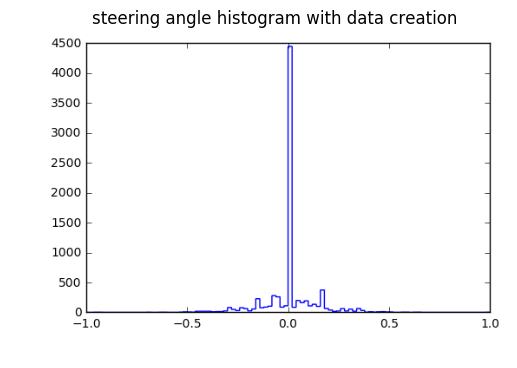

In [4]:
hist_no_creation = mpimg.imread('y_train_cwr2.png')
plt.title('steering angle histogram with data creation')
plt.axis('off')
plt.imshow(hist_no_creation)

### Preprocessing

#### Original Input Image

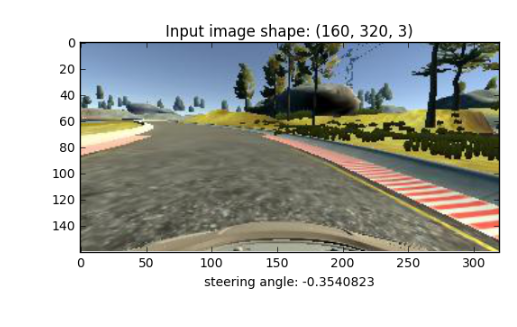

In [86]:
original = mpimg.imread('plots/input_image.png')
plt.axis('off')
plt.imshow(original)

#### Brightness
* I augmented the brightness by a random uniform value, this is because track 2 has shadows and images may appear darker than on track 1

(-0.5, 516.5, 312.5, -0.5)

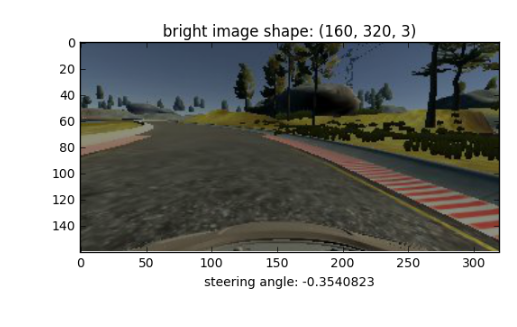

In [85]:
bright = mpimg.imread('plots/bright_image.png')
plt.imshow(bright)
plt.axis('off')

#### Flip
* I vertically flip each image with 50% chance. This is because I only used training data on a counter-clockwise track and I would like it to be able to work on a clockwise track. After flipping the images I inverted the steering angle

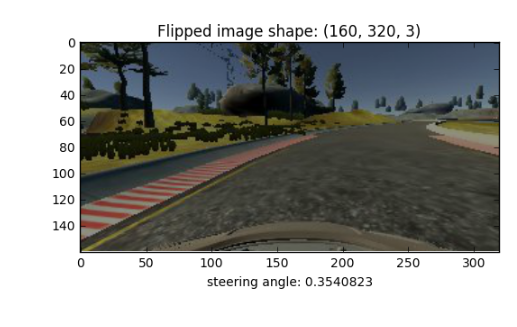

In [87]:
flipped_img = mpimg.imread('plots/flip_image.png')
plt.axis('off')
plt.imshow(flipped_img)

#### Crop
* I cropped each image to subtract the sky and the steering wheel from the height

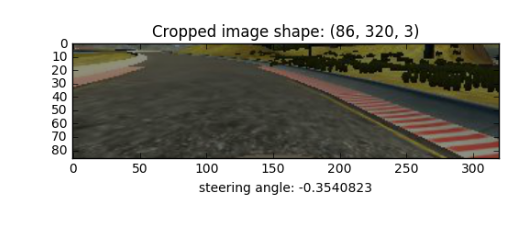

In [88]:
cropped_img = mpimg.imread('plots/cropped_image.png')
plt.axis('off')
plt.imshow(cropped_img)

#### Resize
* I resized each image from (160,320,3) to (66, 220, 3) to accompany The Nvidia Model Architecture

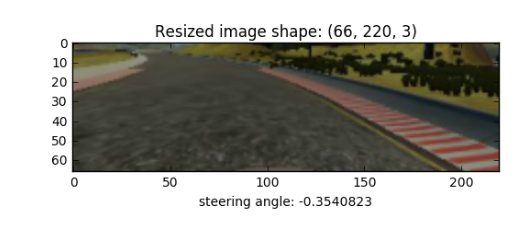

In [89]:
resized = mpimg.imread('plots/resized_image.png')
plt.axis('off')
plt.imshow(resized)

#### Normalization
* I normalized pixel values [0, 255] to be between [-1, 1].

### Generating Batches
I chose to generate batches of my training data instead of yielding a single image each time so I have more control on the distribution of what gets yielded. If I was yielding an image each time, I would increase my `samples_per_epoch` in my `train_generator` to be equal to the number of sample images in my dataset. This way I simply make that a lower number and yield batches. Yielding batches also helps to avoid possible errors if I attempted to control the distribution of center_cam, left_cam, and right_cam images via probability.

#### Validation Generator vs. Training Generator differences

my validation generator sends validation data through a validation pipeline that performs brightness augmentation, cropping, and resizing. (These are also implemented in drive.py). I did not implement flipping and I only included center camera images in the validation pipeline because that is what will be fed into the model when the car is driving in the simulator.

##### Method 1:
I already created additional data for each center_turn, left_turn, and right_turn respectively. What I attempted to do in my generator was double my batch size. From 16 to 32. 
* Immediately push in a center_cam processed image
* 66% chance to push in another center_cam image
* 33% chance to push in a left_cam image
* 33% chance to push in a right_cam image
This will allow me to introduce random left and right cam images into the dataset, creating additional data.
* <strong>This worked! successful track 1</strong> <font color = 'red'>(submitted as `model-F.h5`).</font>

#### Method 2:
The second method was to maintain the batch size at 32 images per batch and to create a 33% chance to push a center_cam, left_cam, or right_cam.
* 33% chance for center_cam
* 33% chance for left_cam
* 33% chance for right_cam

#### Method 3:
The third method was to maintain a batch size at 32 and only push in center images

#### Method 4:
Increase batch size to 256 and only use center images <strong>This worked also </strong>

### Network Architecture

I chose to use the Nvidia model [https://arxiv.org/pdf/1604.07316v1.pdf]. In the preprocessing stages I converted my image from 160,320,3 to 60, 220, 3 (RGB)

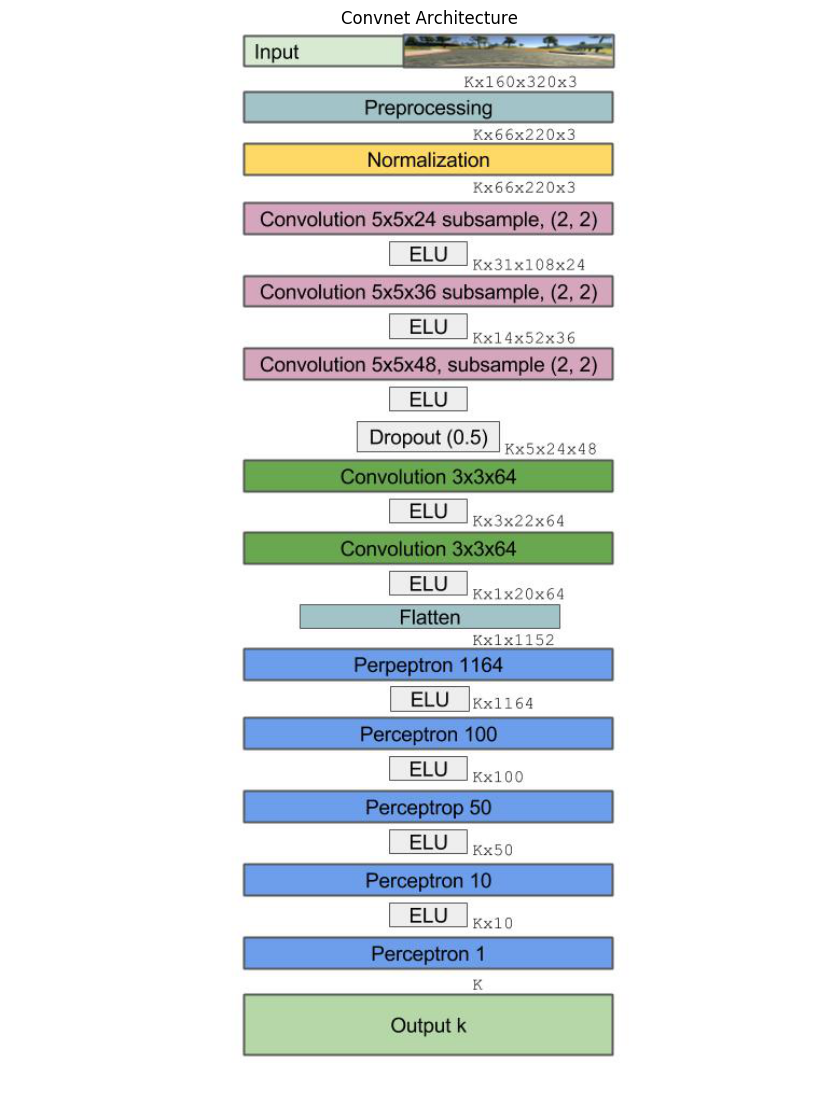

In [92]:
convnet_architecture = mpimg.imread('plots/Convnet Architecture Nvidia Model.jpg')
plt.figure(figsize = (10, 20))
plt.axis('off')
plt.title('Convnet Architecture')
plt.imshow(convnet_architecture)

* attempt 1: I attempted to convert the image to HSV and only normalize the S channel. This turned out not to help that much so I went back to RGB.
* attempt 2: I kept the image as RGB and fed that into the network and performed normalization on all three channels [red, green, blue].

I used ELu's because they push mean unit activation functions closer to zero [https://arxiv.org/pdf/1511.07289v1.pdf].

#### Choice 1: Dropout

I used dropout to increase normalization. I used a dropout `p = 0.5` between the 2nd and 3rd convolutional layers, before applying 64 filters. This basically dropped half the values right in the middle.
* After adding the dropout layer I had to decrease my batch size significantly because I was running out of memory very fast I moved my batch size from 128 to 16 * 2 = 32.

#### Choice 2: No Dropout
* No dropout also worked, but I felt that I was overfitting my model to track 1 and would have no chance performing on track 2 without dropout.

### Training

* I used adam optimization and MSE.
* I used 20k samples per epoch because I have about 80k images and I do not want to sample the entire set each time.

#### Hyperparameters

* <strong> Samples per epoch: 20480 </strong> I am using about 80k images (I created about 4/5 of that). That is a ton of data. Therefore I don't sample every single image on each epoch. I only sample 1/4 of that 80k => 20k images. However, on each of that 20k I am creating batches of 32 images, so I am actually training my model on `20480 * 32 = 655k` images on each epoch. This is because I am randomly grabbing an image in my dataset to throw into the batches, with replacement. Total images processed is  `20480 * 32 * 18 = 11.8M` which is `11.8M * 66 * 220 * 3 =  513B pixels`
* <strong> Number of epochs: 18 </strong> I use 18 epochs, in 3 cycles. I did the three cycles because I want to be able to sequentially train long enough (nb_epochs = 6) and then be able to evaluate that model, if it is good I want to save it. Then I train another 2 models and choose the model with the lowest validation loss. When I tried setting the range to 4 I got a memory error. So 3 was the highest I could go.
* <strong> Batch size: </strong> 16. Then I multiply that batch size * 2 in my generator so it becomes <strong>32</strong>. I tried using a large batch size but I ran out of memory very fast because I was trying to store all those postprocessed images in memory inside the generator function. Lowering the batch size to 32 seemed to work well and it caused my training to speed up as well.
* <strong>nb_val_samples: total length of validation data</strong>. My validation generator simply yields one image each time, so I simply use all the validation data for my validation sample size. This causes all my validation data to load into the generator one by one in a sequential fashion. They would load in order if I had not shuffled the training data before splitting it into training and validation datasets.

### Changes to drive.py
In drive.py I added a function to 1) Augment brightness 2) Crop and 3) resize the images in that order.

## Getting it to work

Most of this project was experimental. I would get the car to drive, and then run into some sort of wall or something. Then I would start tinkering with the preprocessing stages. I did not modify the network architecture that much other than including a dropout layer so I did not overfit my training data. The dropout layer will help me normalize and generalize to track 2.

## Testing

Originally when I tested the model on track 1 I used a speed of 0.8. I was able to almost get past the bridge but I felt I was doing myself a disservice because my model should be able to go full speed. It also took way too long to test it. Eventually I tested the model at speed = 9, which worked.

<strong><font color='green'>You can see the results in the video link here: https://youtu.be/gX1NCGVETNk</font></strong>

### Realizations:
The worst part of this project was myself and my own habits. I wrote so much code that I ended up erasing. I tried to fit my dataset to a gaussian-like multimodal distribution using different steering angles and creating data based on a random gaussian percentage. I spent ~6 hours on this and I ended up scraping it because it didn't work because the mean was 0.004 and the stddev was 0.016 except for the fast that the steering angles are in completely different ranges. 

* My workflow was pretty neat. I trained the models on one computer (with a GPU) and then tested them on a laptop so I could perform a test at the same time I was training the next model with a new modification.